In [ ]:
# Cell 1: Imports and Setup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Enable inline plotting
%matplotlib inline

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [2]:
# Cell 2: Load Data
data_dir = Path("data/generation/eval_results")
files = {
    "CBR Retrieval (k=3)": data_dir / "cbr_retrieval_k3_unified_eval_results.csv",
    "LawRAG Retrieval": data_dir / "lawRAG_retrieval_k_eval_results.csv",
    "Naive Retrieval (k=3)": data_dir / "naive_retrieval_k3_eval_results.csv",
    "No RAG (LLM Only)": data_dir / "no_rag_llm_eval_results.csv"
}

# Load all data
dataframes = {}
for method_name, file_path in files.items():
    try:
        df = pd.read_csv(file_path)
        df['method'] = method_name
        dataframes[method_name] = df
        print(f"Loaded {method_name}: {len(df)} rows")
    except FileNotFoundError:
        print(f"Warning: {file_path} not found, skipping...")

# Combine all dataframes
all_data = pd.concat(dataframes.values(), ignore_index=True)

# Convert numeric columns
numeric_cols = ['faithfulness_score', 'bertscore_f1', 'readability_grade_level', 
                'readability_reading_ease', 'any_correct_law_retrieved', 
                'any_correct_case_retrieved', 'any_correct_retrieved']
for col in numeric_cols:
    if col in all_data.columns:
        all_data[col] = pd.to_numeric(all_data[col], errors='coerce')

print(f"\nTotal rows: {len(all_data)}")
print(f"Methods: {all_data['method'].unique()}")

Loaded CBR Retrieval (k=3): 148 rows
Loaded LawRAG Retrieval: 148 rows
Loaded Naive Retrieval (k=3): 148 rows
Loaded No RAG (LLM Only): 148 rows

Total rows: 592
Methods: ['CBR Retrieval (k=3)' 'LawRAG Retrieval' 'Naive Retrieval (k=3)'
 'No RAG (LLM Only)']


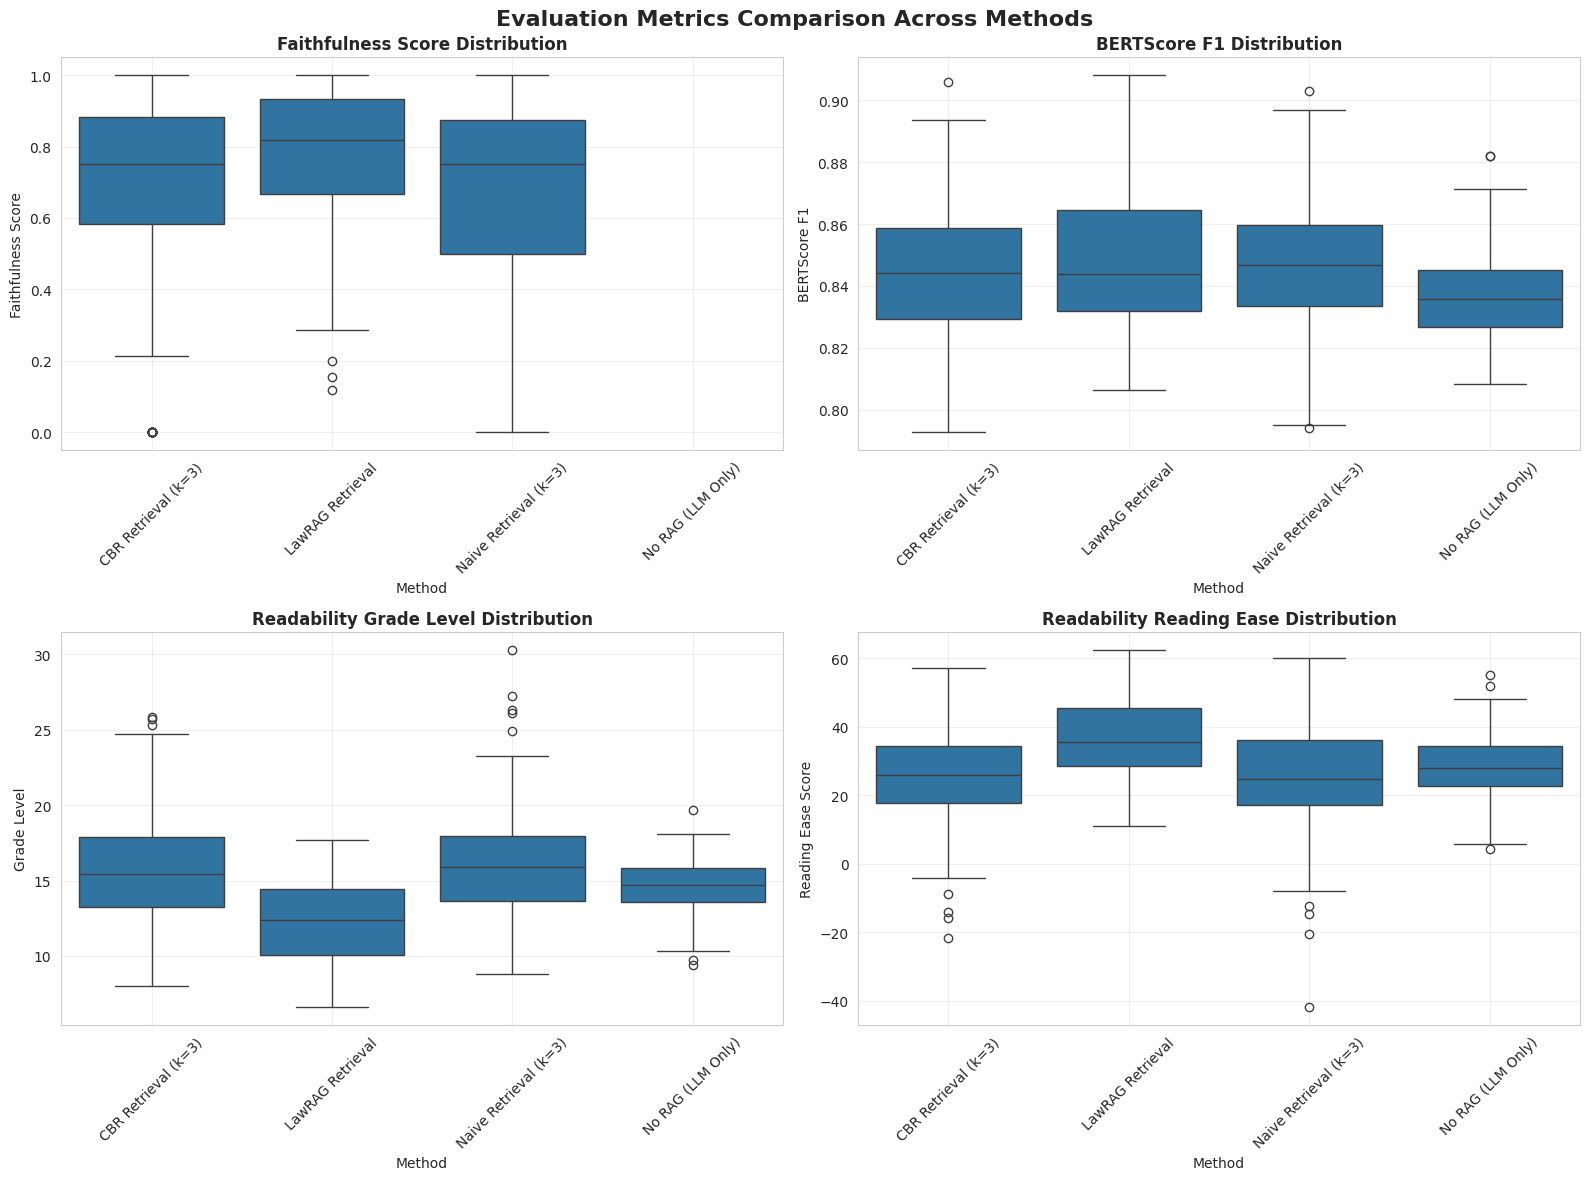

In [3]:
# Cell 3: Box Plots - Evaluation Metrics Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Evaluation Metrics Comparison Across Methods', fontsize=16, fontweight='bold')

# Faithfulness Score
ax1 = axes[0, 0]
sns.boxplot(data=all_data, x='method', y='faithfulness_score', ax=ax1)
ax1.set_title('Faithfulness Score Distribution', fontweight='bold')
ax1.set_xlabel('Method')
ax1.set_ylabel('Faithfulness Score')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# BERTScore F1
ax2 = axes[0, 1]
sns.boxplot(data=all_data, x='method', y='bertscore_f1', ax=ax2)
ax2.set_title('BERTScore F1 Distribution', fontweight='bold')
ax2.set_xlabel('Method')
ax2.set_ylabel('BERTScore F1')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Readability Grade Level
ax3 = axes[1, 0]
sns.boxplot(data=all_data, x='method', y='readability_grade_level', ax=ax3)
ax3.set_title('Readability Grade Level Distribution', fontweight='bold')
ax3.set_xlabel('Method')
ax3.set_ylabel('Grade Level')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

# Readability Reading Ease
ax4 = axes[1, 1]
sns.boxplot(data=all_data, x='method', y='readability_reading_ease', ax=ax4)
ax4.set_title('Readability Reading Ease Distribution', fontweight='bold')
ax4.set_xlabel('Method')
ax4.set_ylabel('Reading Ease Score')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

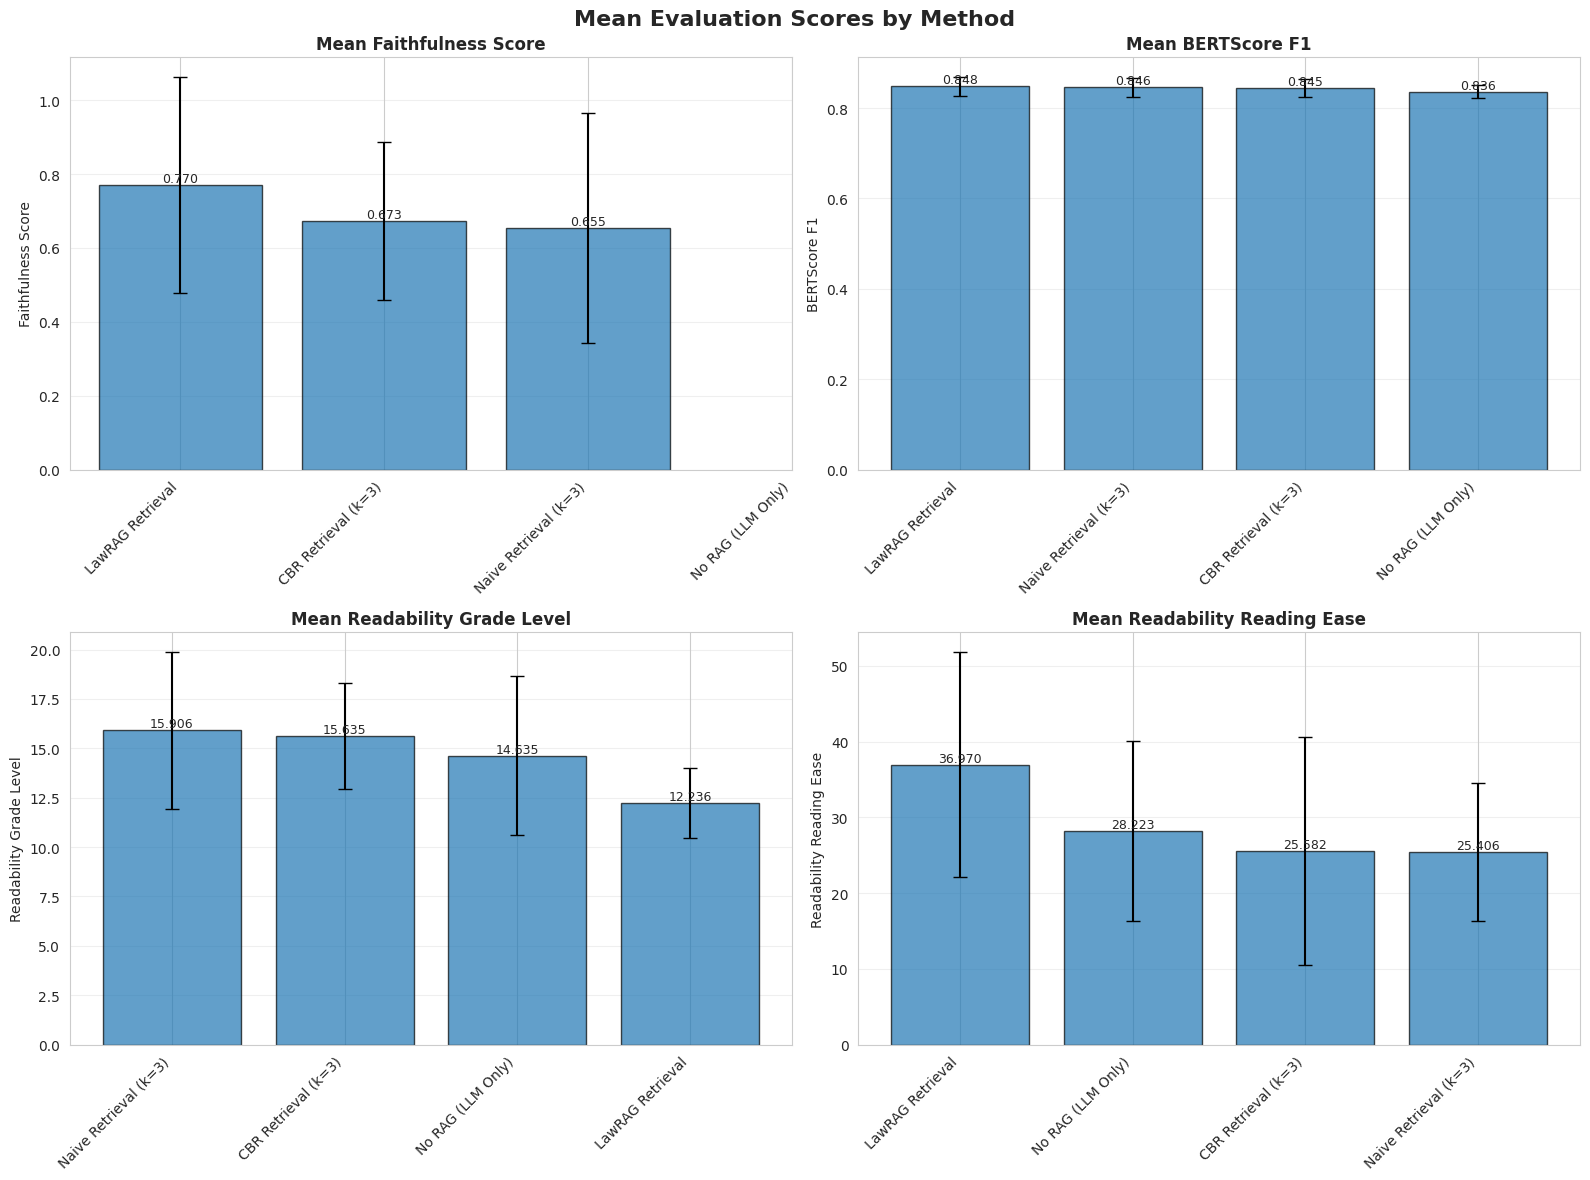

In [4]:
# Cell 4: Mean Scores Bar Charts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Mean Evaluation Scores by Method', fontsize=16, fontweight='bold')

metrics = [
    ('faithfulness_score', 'Faithfulness Score', axes[0, 0]),
    ('bertscore_f1', 'BERTScore F1', axes[0, 1]),
    ('readability_grade_level', 'Readability Grade Level', axes[1, 0]),
    ('readability_reading_ease', 'Readability Reading Ease', axes[1, 1])
]

for metric_col, metric_name, ax in metrics:
    mean_scores = all_data.groupby('method')[metric_col].mean().sort_values(ascending=False)
    std_scores = all_data.groupby('method')[metric_col].std()
    
    bars = ax.bar(range(len(mean_scores)), mean_scores.values, 
                  yerr=std_scores.values, capsize=5, alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(mean_scores)))
    ax.set_xticklabels(mean_scores.index, rotation=45, ha='right')
    ax.set_ylabel(metric_name)
    ax.set_title(f'Mean {metric_name}', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (bar, mean_val) in enumerate(zip(bars, mean_scores.values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{mean_val:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

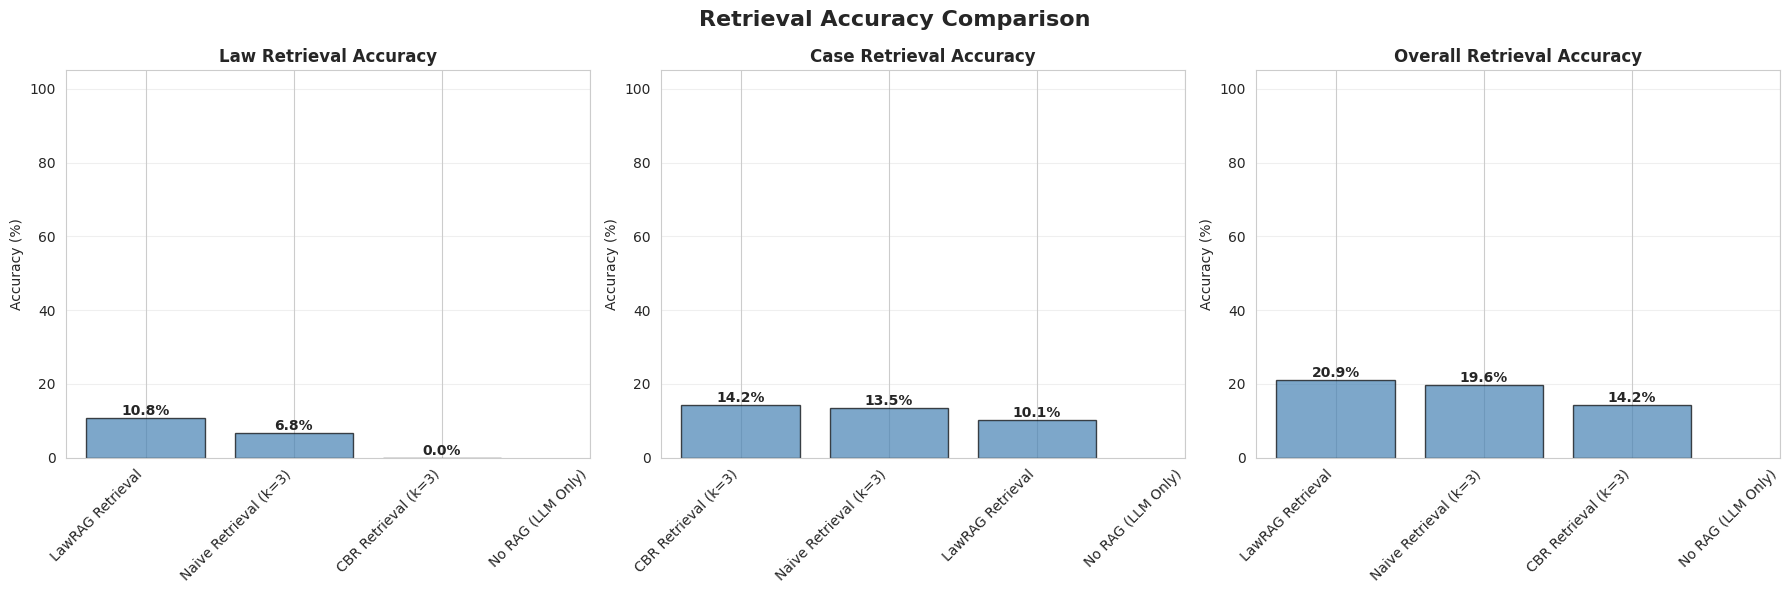

In [5]:
# Cell 5: Retrieval Accuracy Comparison
if 'any_correct_retrieved' in all_data.columns:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Retrieval Accuracy Comparison', fontsize=16, fontweight='bold')
    
    retrieval_metrics = [
        ('any_correct_law_retrieved', 'Law Retrieval Accuracy', axes[0]),
        ('any_correct_case_retrieved', 'Case Retrieval Accuracy', axes[1]),
        ('any_correct_retrieved', 'Overall Retrieval Accuracy', axes[2])
    ]
    
    for metric_col, metric_name, ax in retrieval_metrics:
        if metric_col in all_data.columns:
            # Calculate accuracy (percentage of 1s)
            accuracy = all_data.groupby('method')[metric_col].mean() * 100
            accuracy = accuracy.sort_values(ascending=False)
            
            bars = ax.bar(range(len(accuracy)), accuracy.values, 
                         alpha=0.7, edgecolor='black', color='steelblue')
            ax.set_xticks(range(len(accuracy)))
            ax.set_xticklabels(accuracy.index, rotation=45, ha='right')
            ax.set_ylabel('Accuracy (%)')
            ax.set_title(metric_name, fontweight='bold')
            ax.set_ylim([0, 105])
            ax.grid(True, alpha=0.3, axis='y')
            
            # Add value labels
            for i, (bar, val) in enumerate(zip(bars, accuracy.values)):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("Retrieval accuracy columns not found in data")

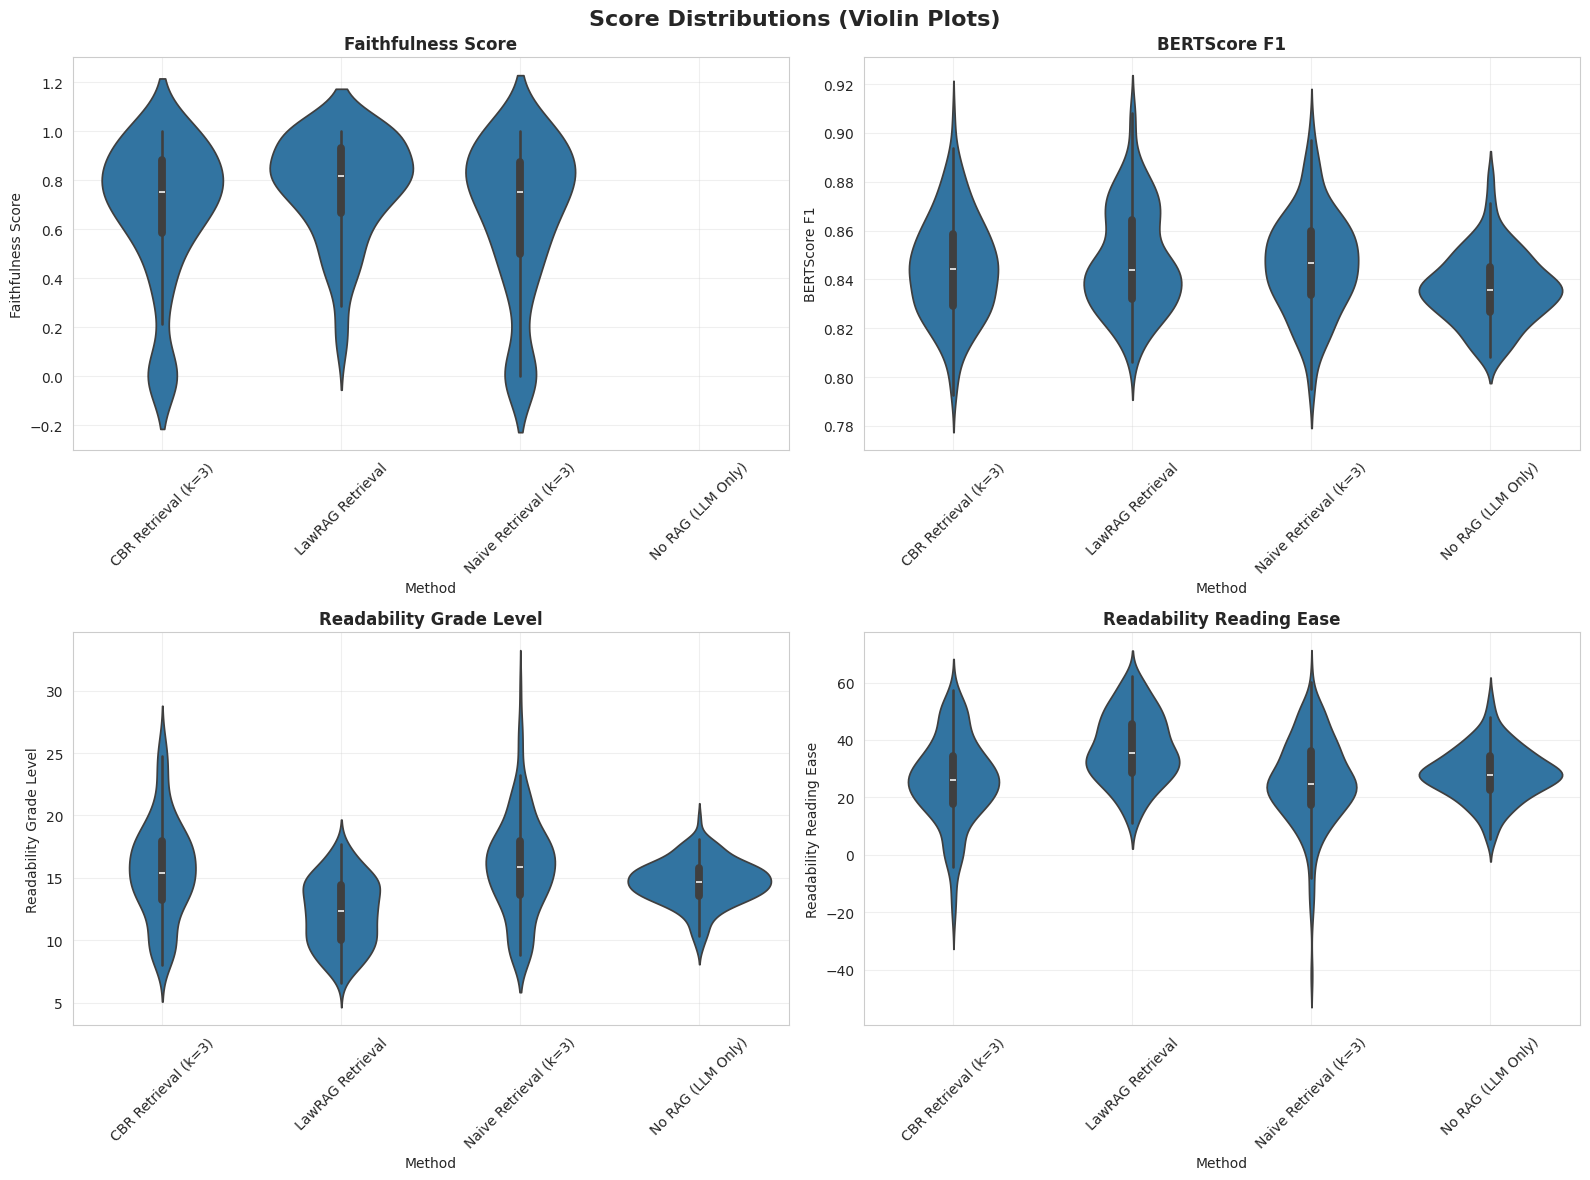

In [6]:
# Cell 6: Violin Plots for Distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Score Distributions (Violin Plots)', fontsize=16, fontweight='bold')

violin_metrics = [
    ('faithfulness_score', 'Faithfulness Score', axes[0, 0]),
    ('bertscore_f1', 'BERTScore F1', axes[0, 1]),
    ('readability_grade_level', 'Readability Grade Level', axes[1, 0]),
    ('readability_reading_ease', 'Readability Reading Ease', axes[1, 1])
]

for metric_col, metric_name, ax in violin_metrics:
    sns.violinplot(data=all_data, x='method', y=metric_col, ax=ax, inner='box')
    ax.set_title(metric_name, fontweight='bold')
    ax.set_xlabel('Method')
    ax.set_ylabel(metric_name)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# Cell 7: Summary Statistics Table
summary_stats = []
for method in all_data['method'].unique():
    method_data = all_data[all_data['method'] == method]
    stats = {
        'Method': method,
        'N': len(method_data),
        'Faithfulness (mean)': method_data['faithfulness_score'].mean(),
        'Faithfulness (std)': method_data['faithfulness_score'].std(),
        'BERTScore F1 (mean)': method_data['bertscore_f1'].mean(),
        'BERTScore F1 (std)': method_data['bertscore_f1'].std(),
        'Grade Level (mean)': method_data['readability_grade_level'].mean(),
        'Grade Level (std)': method_data['readability_grade_level'].std(),
        'Reading Ease (mean)': method_data['readability_reading_ease'].mean(),
        'Reading Ease (std)': method_data['readability_reading_ease'].std(),
    }
    
    if 'any_correct_retrieved' in method_data.columns:
        stats['Retrieval Accuracy (%)'] = method_data['any_correct_retrieved'].mean() * 100
    
    summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
display(summary_df.round(3))

,Method,N,Faithfulness (mean),Faithfulness (std),BERTScore F1 (mean),BERTScore F1 (std),Grade Level (mean),Grade Level (std),Reading Ease (mean),Reading Ease (std),Retrieval Accuracy (%)
0,CBR Retrieval (k=3),148,0.673,0.293,0.845,0.021,15.635,3.974,25.582,14.876,14.189
1,LawRAG Retrieval,148,0.770,0.213,0.848,0.021,12.236,2.676,36.970,11.925,20.946
2,Naive Retrieval (k=3),148,0.655,0.311,0.846,0.021,15.906,4.022,25.406,15.080,19.595
3,No RAG (LLM Only),148,NaN,NaN,0.836,0.015,14.635,1.793,28.223,9.079,NaN


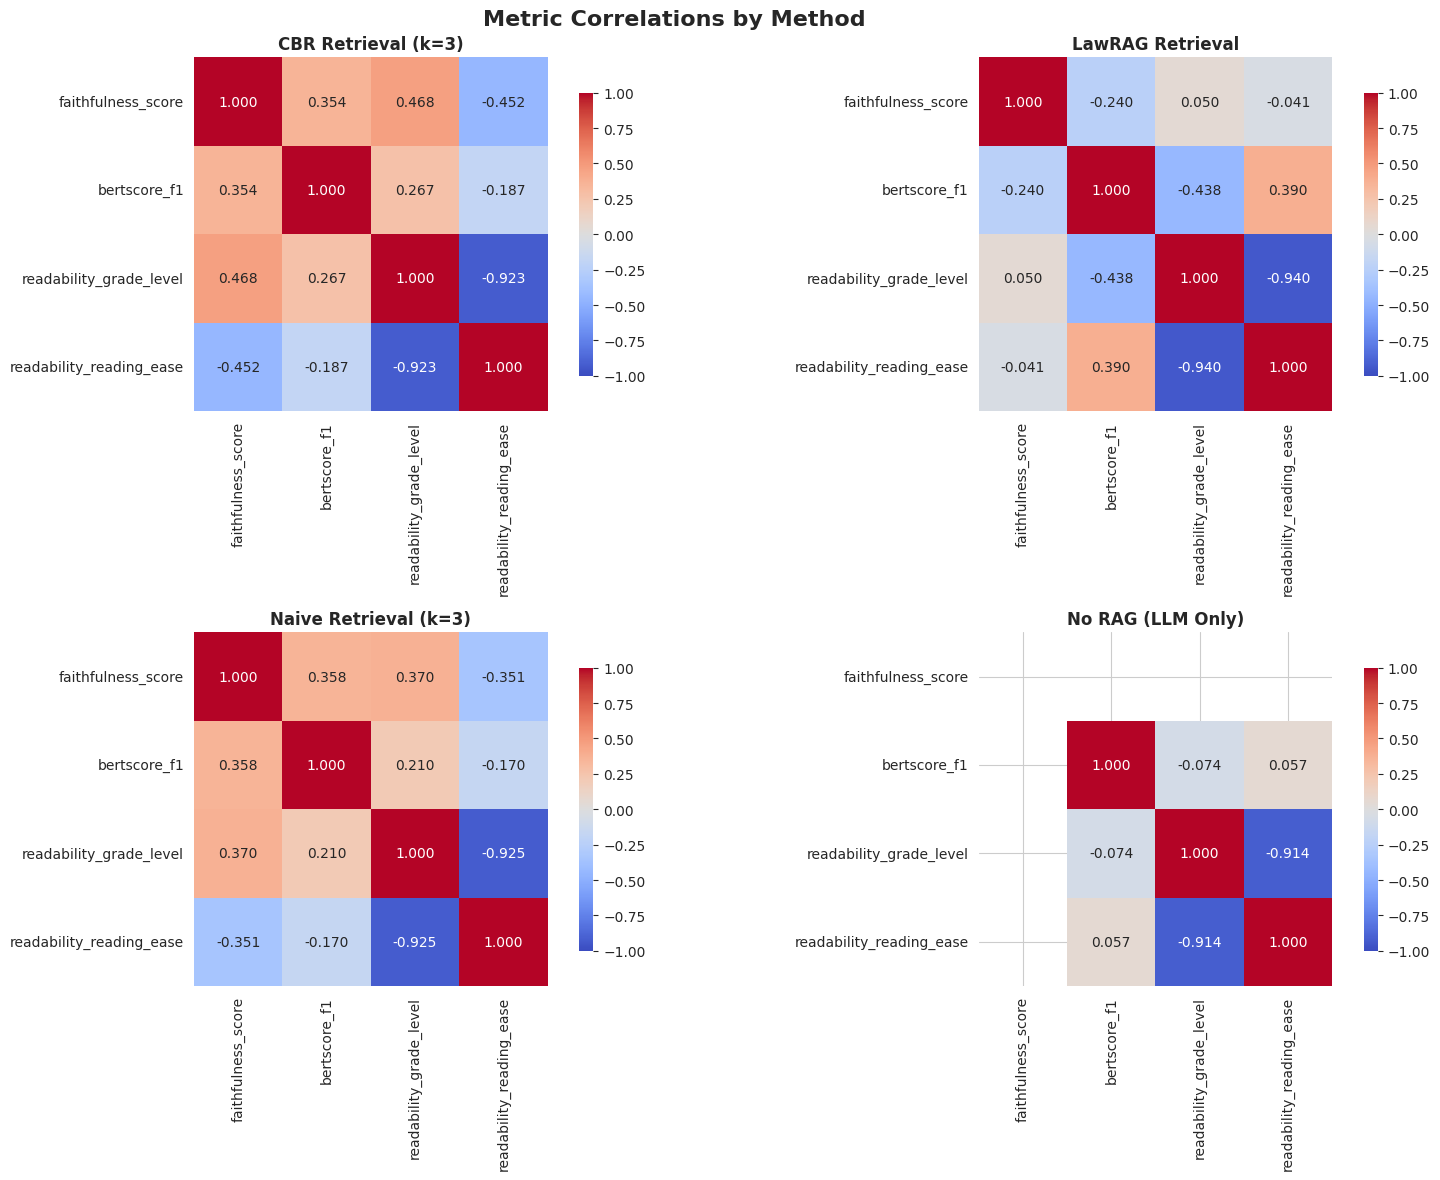

In [8]:
# Cell 8: Correlation Heatmaps
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Metric Correlations by Method', fontsize=16, fontweight='bold')

for idx, method in enumerate(all_data['method'].unique()):
    method_data = all_data[all_data['method'] == method]
    ax = axes[idx // 2, idx % 2]
    
    corr_cols = ['faithfulness_score', 'bertscore_f1', 'readability_grade_level', 
                 'readability_reading_ease']
    corr_data = method_data[corr_cols].corr()
    
    sns.heatmap(corr_data, annot=True, fmt='.3f', cmap='coolwarm', center=0,
                square=True, ax=ax, cbar_kws={'shrink': 0.8}, vmin=-1, vmax=1)
    ax.set_title(f'{method}', fontweight='bold')

plt.tight_layout()
plt.show()

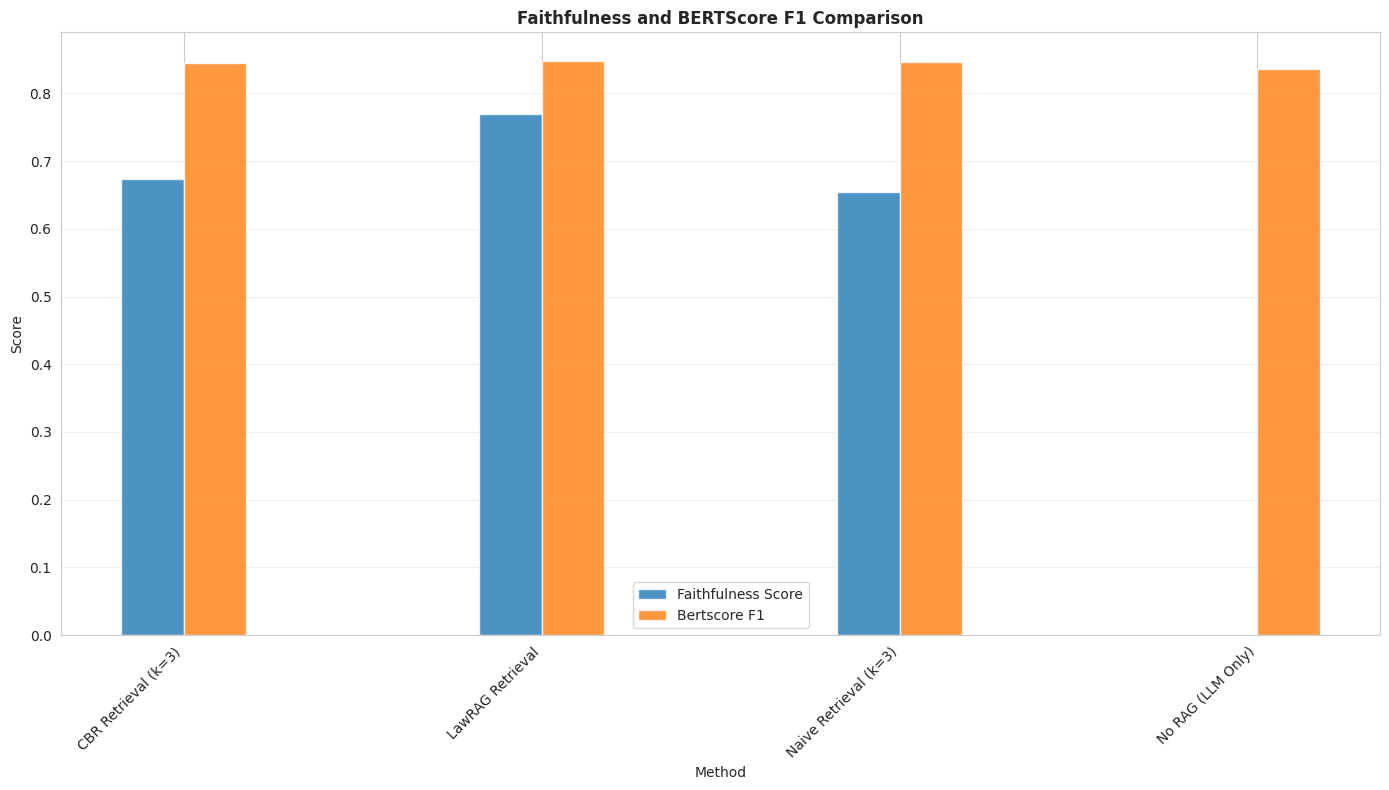

In [9]:
# Cell 9: Side-by-side Faithfulness and BERTScore Comparison
fig, ax = plt.subplots(figsize=(14, 8))

metrics_to_plot = ['faithfulness_score', 'bertscore_f1']
method_order = all_data['method'].unique()
means = {}
for metric in metrics_to_plot:
    means[metric] = [all_data[all_data['method'] == m][metric].mean() for m in method_order]

x_pos = np.arange(len(method_order))
width = 0.35

for i, metric in enumerate(metrics_to_plot):
    offset = (i - len(metrics_to_plot)/2 + 0.5) * width / len(metrics_to_plot)
    ax.bar(x_pos + offset, means[metric], width/len(metrics_to_plot), 
           label=metric.replace('_', ' ').title(), alpha=0.8)

ax.set_xlabel('Method')
ax.set_ylabel('Score')
ax.set_title('Faithfulness and BERTScore F1 Comparison', fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(method_order, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()